# Guide To Ensembling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_ensembling.ipynb
[2]:https://docs.masterfulai.com/0.4.1/notebooks/guide_ensembling.ipynb

In this guide, you'll learn how to create an ensemble model. Ensembles are a common way to train a larger model successfully. In this guide, you'll run an experiment to determine if ensembling is useful for your problem of classifying CIFAR10. You will generate three scenarios to compare:

1) As a first baseline, a model trained without Masterful. 
2) As a second baseline, the same model architecture trained by Masterful including Masterful's regularization techniques. This baseline allows you to to ablate the effects of regularization from ensembling. 
3) An ensemble model created by Masterful, including Masterful's regularization techniques. The null hypothesis you seek to reject is that the Masterful trained ensemble does not deliver better accuracy than the two baselines. 

For more information on the theory of ensembles, see the concepts doc.

## Prerequisites

Please follow the Masterful installation instructions [here](../tutorials/tutorial_installation.md) in order to run this Quickstart.

## Imports

This guide uses [Tensorflow](https://www.tensorflow.org) for training and [Tensorflow Datasets](https://www.tensorflow.org/datasets) for the training data.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import masterful
masterful = masterful.register()

Prepare your dataset. You'll use the MNIST dataset for this guide. 

In [2]:
NUM_CLASSES = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data into the range [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape the data as single channel images.
x_train = tf.reshape(x_train, (-1, 28, 28, 1))
x_test = tf.reshape(x_test, (-1, 28, 28, 1))

# Convert labels to one-hot. 
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

Now, build a simple model architecture. 

In [3]:
def get_model():
  model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(5, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CLASSES),
    ]
  )
  return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 5)         50        
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 980)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                9810      
Total params: 9,860
Trainable params: 9,860
Non-trainable params: 0
_________________________________________________________________


To implement scenario 1, train the model without using Masterful. This will train to 0.96-0.97 accuracy on the validation set. This is a sanity check to ensure that Masterful training improves the model accuracy. 

In [4]:
batch_size = 64
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.CategoricalAccuracy()],
)
model.fit(training_dataset.batch(batch_size), validation_data=test_dataset.batch(batch_size), epochs=20)

Epoch 1/20
938/938 [==============================] - 16s 4ms/step - loss: 0.8121 - categorical_accuracy: 0.7878 - val_loss: 0.2886 - val_categorical_accuracy: 0.9167
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2836 - categorical_accuracy: 0.9205 - val_loss: 0.2365 - val_categorical_accuracy: 0.9335
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2374 - categorical_accuracy: 0.9330 - val_loss: 0.2016 - val_categorical_accuracy: 0.9437
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2052 - categorical_accuracy: 0.9425 - val_loss: 0.1798 - val_categorical_accuracy: 0.9489
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1846 - categorical_accuracy: 0.9486 - val_loss: 0.1657 - val_categorical_accuracy: 0.9534
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1712 - categorical_accuracy: 0.9519 - val_loss: 0.1558 - val_categorical_accuracy: 0.9558
Epo

In [5]:
baseline_eval_metrics = model.evaluate(test_dataset.batch(128))
baseline_val_loss, baseline_val_accuracy = baseline_eval_metrics

79/79 [==============================] - 0s 3ms/step - loss: 0.1268 - categorical_accuracy: 0.9610


## Train with Masterful

You can implement scenario 2 and 3 at the same time. The Masterful ensembling API will train multiple individual models and report on their accuracy before ensembling and reporting on the ensemble's accuracy. 

The Masterful AutoML platform learns how to train your model by focusing on five core organizational principles in deep learning: architecture, data, optimization, regularization, and semi-supervision.

**Architecture** is the structure of weights, biases, and activations that define a model. In this example, the architecture is defined by the model you created above. Importantly, we will use the [ensemble_multiplier](../api/api_architecture.rst#masterful.architecture.ArchitectureParams) parameter of the [ArchitectureParams](../api/api_architecture.rst#masterful.architecture.ArchitectureParams) structure to specifiy how many models we will ensemble together.

**Data** is the input used to train the model. In this example, you are using a labeled training dataset of flowers. More advanced usages of the Masterful AutoML platform can take into account unlabeled and synthetic data as well, using a variety of different techniques.

**Optimization** means finding the best weights for a model and training data. Optimization is different from regularization because optimization does not consider generalization to unseen data. The central challenge of optimization is speed - find the best weights faster.

**Regularization** means helping a model generalize to data it has not yet seen. Another way of saying this is that regularization is about fighting overfitting.

**Semi-Supervision** is the process by which a model can be trained using both labeled and unlabeled data.

The first step when using Masterful is to learn the optimal set of parameters for each of the five buckets above. You start by learning the architecture and data parameters of the model and training dataset. In the code below, you are telling Masterful that your model is performing a classification task (`masterful.enums.Task.CLASSIFICATION`) with 10 labels (`num_classes=NUM_CLASSES`), and that the input range of the image features going into your model are in the range [0,1] (`input_range=masterful.enums.ImageRange.ZERO_ONE`). Also, the model outputs logits rather than a softmax classification (`prediction_logits=True`). Note the `ensemble_multiplier` parameter, set to 5, which tells Masterful to train and ensemble 5 different models and average the results of the joint prediction.

Furthermore, in the training dataset, you are providing dense labels (`sparse_labels=False`) rather than sparse labels.

For more details on architecture and data parameters, see the API specifications for [ArchitectureParams](../api/api_architecture.rst#masterful.architecture.ArchitectureParams) and [DataParams](../api/api_data.rst#masterful.data.DataParams). 

In [6]:
model_params = masterful.architecture.learn_architecture_params(
  model=model,
  task=masterful.enums.Task.CLASSIFICATION,
  input_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  prediction_logits=True,
  ensemble_multiplier=5,
)
training_dataset_params = masterful.data.learn_data_params(
  dataset=training_dataset,
  task=masterful.enums.Task.CLASSIFICATION,
  image_range=masterful.enums.ImageRange.ZERO_ONE,
  num_classes=NUM_CLASSES,
  sparse_labels=False,
)

Next you learn the optimization parameters that will be used to train the model. Below, you use Masterful to learn the standard set of optimization parameters to train your model for a classification task.

For more details on the optmization parameters, please see the [OptimizationParams](../api/api_optimization.rst#masterful.optimization.OptimizationParams) API specification.

In [ ]:
optimization_params = masterful.optimization.learn_optimization_params(
  model,
  model_params,
  training_dataset,
  training_dataset_params,
)

The regularization parameters used can have a dramatic impact on the final performance of your trained model. Learning these parameters can be a time-consuming and domain specific challenge. Masterful can speed up this process by learning these parameters for you. In general, this can be an expensive operation. A rough order of magnitude for learning these parameters is 2x the time it takes to train your model. However, this is still dramatically faster than manually finding these parameters yourself. In the example below, you will use the [learn_regularization_params](../api/api_regularization.rst#masterful.regularization.learn_regularization_params) API to learn these parameters directly from your dataset and model.

For more details on the regularization parameters, please see the [RegularizationParams](../api/api_regularization.rst#masterful.regularization.RegularizationParams) API specification.

In [ ]:
regularization_params = masterful.regularization.learn_regularization_params(
  model,
  model_params,
  optimization_params,
  training_dataset,
  training_dataset_params,
)

The final step before training is to learn the optimal set of semi-supervision parameters. For this Quickstart, we are not using any unlabeled or synthetic data as part of training, so most forms of semi-supervision will be disabled by default.

For more details on the semi-supervision parameters, please see the [SemiSupervisedParams](../api/api_ssl.rst#masterful.ssl.SemiSupervisedParams) API specification.

In [ ]:
ssl_params = masterful.ssl.learn_ssl_params(
  training_dataset,
  training_dataset_params,
)

Now, you are ready to train your model using the Masterful AutoML platform. In the next cell, you will see the call to [masterful.training.train](../api/api_training.rst#masterful.training.train), which is the entry point to the meta-learning engine of the Masterful AutoML platform. Notice there is no need to batch your data (Masterful will find the optimal batch size for you). No need to shuffle your data (Masterful handles this for you). You don't even need to pass in a validation dataset (Masterful finds one for you). You hand Masterful a model and a dataset, and Masterful will figure the rest out for you. Ensembling with Masterful looks exactly the same as non-ensemble training with Masterful. Masterful handles everything for you inside the API.

In [9]:
training_report = masterful.training.train(
  model, 
  model_params, 
  optimization_params,
  regularization_params,
  ssl_params,
  training_dataset,
  training_dataset_params,
)

Fitting model phase 2 of 2 DONE.
Masterful backend.fit() DONE.


Now that the ensemble is trained, access it using the report returned and evaluate on the `test_dataset`. 

In [10]:
print('Evaluating ensembled model...')
ensembled_model = training_report.model
ensembled_results = ensembled_model.evaluate(test_dataset.batch(64), return_dict=True)

Evaluating ensembled model...
157/157 [==============================] - 1s 4ms/step - loss: 0.0560 - categorical_accuracy: 0.9824


In [11]:
training_report.validation_results

{'loss': 0.0560285821557045,
 'categorical_accuracy': 0.9824000000953674,
 'child_models': {0: {'loss': 0.07878458499908447,
   'categorical_accuracy': 0.9750999808311462},
  1: {'loss': 0.06273771077394485, 'categorical_accuracy': 0.98089998960495},
  2: {'loss': 0.069137804210186, 'categorical_accuracy': 0.9787999987602234},
  3: {'loss': 0.061786066740751266, 'categorical_accuracy': 0.980400025844574},
  4: {'loss': 0.06251046806573868,
   'categorical_accuracy': 0.9807000160217285}}}

The report also holds metrics on the child models. Access them, average, and plot the results. You've successfully demonstrated that an ensemble outperforms both individual child models, as well as a model trained without any of Masterful's techniques. 

157/157 [==============================] - 1s 3ms/step - loss: 0.0750 - categorical_accuracy: 0.9781


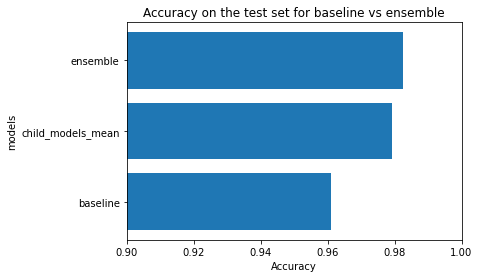

In [12]:
import matplotlib.pyplot as plt
models = ['baseline', 'child_models_mean', 'ensemble']
accuracies = [baseline_val_accuracy]
accuracies_children = []

for ensemble_child_model in ensembled_model.layers[1:6]:
    ensemble_model_child_results = ensemble_child_model.evaluate(test_dataset.batch(batch_size), return_dict=True)
    accuracies_children.append(ensemble_model_child_results['categorical_accuracy'])

mean_accuracy_children = np.mean(np.array(accuracies_children))
accuracies.append(mean_accuracy_children)

accuracies.append(ensembled_results['categorical_accuracy'])

plt.barh(models,accuracies)
plt.title('Accuracy on the test set for baseline vs ensemble')
plt.ylabel('models')
plt.xlabel('Accuracy')
plt.xlim([0.90, 1.0])
plt.show()